In [282]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 1 Neural Networks using Numpy [20pts]

Code provided

In [283]:
# Load the data
def load_data():
    with np.load("notMNIST.npz") as data:
        data, targets = data["images"], data["labels"]
        
        np.random.seed(521)
        rand_idx = np.arange(len(data))
        np.random.shuffle(rand_idx)
        
        data = data[rand_idx] / 255.0
        targets = targets[rand_idx].astype(int)
        
        train_data, train_target = data[:10000], targets[:10000]
        valid_data, valid_target = data[10000:16000], targets[10000:16000]
        test_data, test_target = data[16000:], targets[16000:]
    return train_data, valid_data, test_data, train_target, valid_target, test_target


# Description: convert to one-hot encoding
def convert_onehot(train_target, valid_target, test_target):
    new_train = np.zeros((train_target.shape[0], 10))
    new_valid = np.zeros((valid_target.shape[0], 10))
    new_test = np.zeros((test_target.shape[0], 10))

    for item in range(0, train_target.shape[0]):
        new_train[item][train_target[item]] = 1
    for item in range(0, valid_target.shape[0]):
        new_valid[item][valid_target[item]] = 1
    for item in range(0, test_target.shape[0]):
        new_test[item][test_target[item]] = 1
    return new_train, new_valid, new_test


def shuffle(data, target):
    np.random.seed(421)
    rand_idx = np.random.permutation(len(data))
    return data[rand_idx], target[rand_idx]

## 1.1 Helper Functions

relu

In [284]:
# Implementation of a neural network using only Numpy - trained using gradient descent with momentum
def relu(x):
    return np.maximum(0, x)

# test
print(relu(3))
print(relu(-1))

3
0


softmax

$$\sigma(\mathbf{z})_{j}=\frac{\exp \left(z_{j}\right)}{\sum_{k=1}^{K} \exp \left(z_{k}\right)}, \quad j=1, \cdots, K \text { for } \mathrm{K} \text { classes }$$

In [285]:
# Description: takes in a vector, and calculate the probability of each output
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True) # subtract the maximum value of x from all its elements to prevent overflow
    num = np.exp(x)
    den = np.sum(num, axis=-1, keepdims=True)
    x = num / den
    return x  

# test
test_arr = np.array([1, 2, 3, 4])
print(softmax(test_arr))

[0.0320586  0.08714432 0.23688282 0.64391426]


compute_layer

In [286]:
# Description: Compute matrix product of weight, input, then add the bias
def compute_layer(X, W, b):
    return np.add(np.matmul(X, W), b)

# test
test_X = np.array([1, 2])
test_W = np.array([[1, 2], [3, 4]])
test_b = np.array([1, 1])
print(compute_layer(test_X, test_W, test_b))


[ 8 11]


average_ce

In [287]:
def average_ce(target, prediction):
    #* note the prediction should be generated through softmax, not directly from s_o
    log_pred = np.log(prediction)
    average_ce = -np.mean(target * log_pred)
    return average_ce

# test
test_target = np.array([1, 2])
test_pred = np.array([2, 2])
print(average_ce(test_target, test_pred))


-1.0397207708399179


grad_ce

Calculation of the derivative of softmax function

$$\mathbf{s}(\mathbf{z})_{j}=\frac{\exp \left(z_{j}\right)}{\sum_{k=1}^{K} \exp \left(z_{k}\right)}, \quad j=1, \cdots, K \text { for } \mathrm{K} \text { classes }$$

$$
\mathbf{s}(\mathbf{z})=\frac{e^{\mathbf{z}}}{\sum_{k=1}^{K} e^{z_k}}
$$

$$
\begin{aligned}
\frac{\partial \mathbf{s}(\mathbf{z})}{\partial \mathbf{z}} &=\frac{e^{\mathbf{z}}\left(\sum_{k=1}^{K} e^{z_{k}}\right)-e^{\mathbf{z}} \cdot e^{\mathbf{z}}}{\left(\sum_{k=1}^{K} e^{z_{k}}\right)^{2}}
\\&=\frac{e^{\mathbf{z}}}{\sum_{k=1}^{K} e^{z_{k}}} \cdot \frac{\sum_{k=1}^{K} e^{z_{k}}-e^{\mathbf{z}}}{\sum_{k=1}^{K} e^{z_{k}}} \\
&=\mathbf{s}(\mathbf{z})\cdot [1-\mathbf{s}(\mathbf{z})]
\end{aligned}
$$

Expression for cross entropy for $N$ input data $\mathbf{z}$ and $K$-classes is

$$
\begin{aligned}
\mathcal{L}_{CE}&=- \sum_{n=1}^{N}  y_{n} \log \left[\mathbf{s}(\mathbf{z})_{n}\right]
\\ &=- \mathbf{y}^{T} \log \left[\mathbf{s}(\mathbf{z})\right]
\end{aligned}
$$

Derivative of $\mathcal{L}_{C E}$ with respect to $\mathbf{s}$ is 

$$
\begin{aligned}
\frac{\partial \mathcal{L}_{C E}}{\partial \mathbf{s}} &=- \mathbf{y}^{T} \log \left[\mathbf{s}(\mathbf{z})\right]
\\&=-\mathbf{y}^{T}\frac{1}{\mathbf{s}(\mathbf{z})}
\end{aligned}
$$


Using the chain rule, we calculate the derivative of $\mathcal{L}_{C E}$ with respect to $\mathbf{z}$ 

$$
\begin{aligned}
\frac{\partial \mathcal{L}_{C E}}{\partial \mathbf{z}} 
&= \frac{\partial \mathcal{L}_{C E}}{\partial \mathbf{s}} \cdot \frac{\partial \mathbf{s}}{\partial \mathbf{z}}
\\&=-\mathbf{y}^{T}\frac{1}{\mathbf{s}(\mathbf{z})} \cdot \mathbf{s}(\mathbf{z})[1-\mathbf{s}(\mathbf{z})]
\\&=\mathbf{s}(\mathbf{z})-\mathbf{y}
\end{aligned}
$$


In [288]:
# Description: calculate cross-entropy loss
def grad_ce(target, logits):
    # logits is the input to the softmax function
    #* grad_ce does not calculate the average ce, should divide by the size of target to get the step size when training
    return softmax(logits) - target

## 1.2 Backpropagation Derivation [8 pts.]

1. $$\frac{\partial \mathcal{L}}{\partial {W}_{o}}$$

Gradient of the loss with respect to the output layer weights [2pts]

Shape: (H × 10), with H units

Loss of the output layer $\ell_o$ with respect to output layer weights depends on the input $\mathbf{s}_o$ of the layer $\ell_o$, output $\mathbf{x}_o$ of the layer $\ell_o$, and the loss function $\mathbf{s}(\mathbf{z})$.
$$
\frac{\partial \mathrm{s}_{o}}{\partial W_{o}}=\frac{\partial}{\partial W_{o}}\left(\mathbf{x}_{h} W_{o}+b_{o}\right)=\mathbf{x_h}
$$

$$
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial {W}_{o}}&=\frac{\partial \mathcal{L}_{CE}}{\partial \mathbf{x}_{o}} \frac{\partial \mathbf{x}_{o}}{\partial \mathbf{s}_{o}}\frac{\partial \mathbf{s}_{o}}{\partial {W}_
{o}}
\\&= \mathbf{x}_{h}^{T}[\mathbf{s}(\mathbf{x_o})-\mathbf{y}]
\end{aligned}
$$

where $\mathbf{x}_{h}$ is the output of the hidde layer $\ell_h$

p.s. first two partial derivative is derived from last question

In [289]:
def grad_W_o(target, s_o, x_h):
    dL_dso =  grad_ce(target, s_o)
    dL_dWo = np.matmul(np.transpose(x_h), dL_dso)
    return dL_dWo / target.shape[0]

2. 
$$\frac{\partial \mathcal{L}}{\partial \mathbf{b}_{o}}$$

Gradient of the loss with respect to the output layer biases. [2pts]

Shape: (1 × 10)

Loss of the output layer $\ell_o$ with respect to output layer bias depends on the input $\mathbf{s}_o$ of the layer $\ell_o$, output $\mathbf{x}_o$ of the layer $\ell_o$, and the unit vector $\mathbf{1} \in \mathbb{R}^{N \times 1}$, whose elements are all one.

$$
\frac{\partial \mathrm{s}_{o}}{\partial b_{o}}=\frac{\partial}{\partial b_{o}}\left(\mathbf{x}_{h} W_{o}+b_{o}\right)=\mathbf{1}
$$

$$
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial {W}_{o}}&=\frac{\partial \mathcal{L}_{CE}}{\partial \mathbf{x}_{o}} \frac{\partial \mathbf{x}_{o}}{\partial \mathbf{s}_{o}}\frac{\partial \mathbf{s}_{o}}{\partial {b}_
{o}}
\\&= \mathbf{1}^{T}\left(\mathbf{s}(\mathbf{x_o})-\mathbf{y}\right) 
\end{aligned}
$$

In [290]:
def grad_b_o(target, s_o):
    dL_dso = grad_ce(target, s_o)
    dso_dbo = np.ones((target.shape[0],1))
    dL_dbo = np.matmul(np.transpose(dL_dso), dso_dbo)
    return sum(dL_dbo) / target.shape[0]

3. 
$$\frac{\partial \mathcal{L}}{\partial {W}_{h}}$$

Gradient of the loss with respect to the output layer weights. [2pts]

Shape: ($F \times H$), with $F$ features, $H$ units

$$
\frac{\partial \mathcal{L}}{\partial W_{h}}=\frac{\partial \mathcal{L}_{CE}}{\partial \mathbf{x}_{o}} \frac{\partial \mathbf{x}_{o}}{\partial \mathbf{s}_{o}} \frac{\partial \mathbf{s}_{o}}{\partial \mathbf{x}_{h}}\cdot \frac{\partial \mathbf{x}_{h}}{\partial \mathbf{s}_{h}} \frac{\partial \mathbf{s}_{h}}{\partial {W}_{h}}
$$
The dot product separate the output layer and the hidden layer.

The first two terms of output layer is calculated in previous question as $\mathbf{s}(\mathbf{x_o})-\mathbf{y}$


The third term $\frac{\partial \mathbf{s}_{o}}{\partial \mathbf{x}_{h}}$ is calculated as
$$
\frac{\partial \mathbf{s}_{o}}{\partial \mathbf{x}_{h}}
=\frac{\partial}{\partial x_{h}}\left(x_{h} W_{o}+b_{o}\right)=W_{o}
$$

The fourth term $\frac{\partial \mathbf{x}_{h}}{\partial \mathbf{s}_{h}}$ is the derivative of the RELU function, which is $\mathbf{1}$ for $\mathbf{s}_{h} > 0$
$$
\frac{\partial \mathbf{x}_{h}}{\partial \mathbf{s}_{h}}=\frac{\partial}{\partial \mathbf{s}_{h}}\left(\operatorname{ReLU}\left(\mathbf{s}_{h}\right)\right)=\mathbf{1}(\mathbf{x_h}>0)
$$

The fifth term $\frac{\partial \mathbf{s}_{h}}{\partial W_{h}}$ is calculated as
$$\frac{\partial}{\partial W_{h}}\left(\mathbf{x}_{in} W_{h}+b_{h}\right) $$

Thus, the result should be 
$$
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial W_{h}}&=\frac{\partial \mathcal{L}_{CE}}{\partial \mathbf{x}_{o}} \frac{\partial \mathbf{x}_{o}}{\partial \mathbf{s}_{o}} \frac{\partial \mathbf{s}_{o}}{\partial \mathbf{x}_{h}}\cdot \frac{\partial \mathbf{x}_{h}}{\partial \mathbf{s}_{h}} \frac{\partial \mathbf{s}_{h}}{\partial {W}_{h}}
\\&=\mathbf{x}_{in}^{T}(\mathbf{s(x_o)}-\mathbf{y}) W_{o}^{T} \mathbf{1}\left(\mathbf{x}_{h}>0\right)
\end{aligned}
$$

In [291]:
def grad_W_h(target, s_o, x_in, x_h, W_o):
    dL_dso = grad_ce(target, s_o)
    dL_dxh = np.matmul(dL_dso, np.transpose(W_o))
    
    # relu activation function only depends on the value of x_h
    dxh_dsh = x_h
    dxh_dsh [dxh_dsh <= 0] = 0
    dxh_dsh [dxh_dsh > 0] = 1
    
    dL_dsh = dL_dxh * dxh_dsh
    dL_dWh = np.matmul(np.transpose(x_in), dL_dsh)
    return dL_dWh / target.shape[0]

4. 
$$\frac{\partial \mathcal{L}}{\partial \mathbf{b}_{h}}$$

Gradient of the loss with respect to the output layer biases. [2pts]

Shape: ($F \times H$), with $F$ features, $H$ units

The result is calculated similar to the previous one, except for the last derivative $\frac{\partial \mathbf{s}_{h}}{\partial {b}_{h}}$

$$
\frac{\partial \mathbf{s}_{h}}{\partial {b}_{h}}=\frac{\partial}{\partial b_{h}}\left(\mathbf{x}_{in} W_{h}+b_{h}\right)=\mathbf{1}
$$

Thus, the result should be

$$
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial b_{h}}&=\frac{\partial \mathcal{L}_{CE}}{\partial \mathbf{x}_{o}} \frac{\partial \mathbf{x}_{o}}{\partial \mathbf{s}_{o}} \frac{\partial \mathbf{s}_{o}}{\partial \mathbf{x}_{h}}\cdot \frac{\partial \mathbf{x}_{h}}{\partial \mathbf{s}_{h}} \frac{\partial \mathbf{s}_{h}}{\partial {b}_{h}}
\\&=\mathbf{1}^{T}(\mathbf{s(x_o)}-\mathbf{y}) W_{o}^{T} \mathbf{1}\left(\mathbf{x}_{h}>0\right)
\end{aligned}

$$

In [292]:
def grad_b_h(target, s_o, x_h, W_o):
    dL_dso = grad_ce(target, s_o)
    dL_dxh = np.matmul(dL_dso, np.transpose(W_o))

    dxh_dsh = x_h
    dxh_dsh[dxh_dsh <= 0] = 0
    dxh_dsh[dxh_dsh > 0] = 1

    dL_dsh = dL_dxh * dxh_dsh
    dL_dbh = np.matmul(np.ones((1, x_h.shape[0])), dL_dsh)
    return dL_dbh / target.shape[0]


# 1.3  Learning [6 pts.]

Function for ploting the accuracy and loss with epoches

In [305]:
def plot_curves(train_acc, train_loss, val_acc, val_loss, test_acc, test_loss):
    num = len(train_acc)

    plt.figure(figsize=(12, 8))
    plt.title("Training Loss vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.plot(range(1, 1 + num), train_loss, 'g', label="Train")
    plt.plot(range(1, 1 + num), val_loss, 'b', label="Validation")
    #plt.plot(range(1, 1 + num), test_loss, 'r', label="Test")
    plt.legend(loc='best')
    plt.show()

    print("Final round loss: ")
    print(f"Training Loss: {train_loss[-1]}")
    print(f"Validation Loss: {val_loss[-1]}")
    print(f"Testing Loss: {test_loss[-1]}")

    plt.figure(figsize=(12, 8))
    plt.title("Training Accuracy vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.plot(range(1, 1 + num), train_acc, 'g', label="Train")
    plt.plot(range(1, 1 + num), val_acc, 'b', label="Validation")
    #plt.plot(range(1, 1 + num), test_acc, 'r', label="Test")
    plt.legend(loc='best')
    plt.show()

    print("Final round accuracy: ")
    print(f"Final Training Accuracy: {train_acc[-1]}")
    print(f"Final Validation Accuracy: {val_acc[-1]}")
    print(f"Final Testing Accuracy: {test_acc[-1]}")


Helper function for forward and backward pass, used in training epoches

In [294]:
def forward_pass (x_in, W_h, b_h, W_o, b_o):
    s_h = compute_layer(x_in, W_h, b_h)
    x_h = relu(s_h)
    o = compute_layer(x_h, W_o, b_o)
    return s_h, x_h, o

In [300]:
# Description: gradient descent wit momentum
def backward_pass(x_in, x_h, s_o, W_h, W_o, b_h, b_o, target, vW_h, vb_h, vW_o, vb_o, gamma, alpha):
    # choose gamma = 0.99 and alpha = 0.1
    vW_h = gamma * vW_h + alpha * grad_W_h(target, s_o, x_in, x_h, W_o)
    W_h -= vW_h

    vb_h = gamma * vb_h + alpha * grad_b_h(target, s_o, x_h, W_o)
    b_h -= vb_h

    vW_o = gamma * vW_o + alpha * grad_W_o(target, s_o, x_h)
    W_o -= vW_o

    vb_o = gamma * vb_o + alpha * grad_b_o(target, s_o)
    b_o -= vb_o

    return W_h, b_h, W_o, b_o, vW_h, vb_h, vW_o, vb_o


Helper function for Xaiver initialization

In [296]:
# Description: Initialize weights following the Xaiver initialization scheme
def XavierInit(units_in, units_out):
    return np.random.normal(0, np.sqrt(2.0 / (units_in + units_out)), (units_in, units_out)) # mean, variance and dimension

Import data

In [297]:
# import data and convert from notMNIST to one-hot target
trainData, validData, testData, trainTarget, validTarget, testTarget = load_data()

trainData = trainData.reshape(trainData.shape[0], -1)
validData = validData.reshape(validData.shape[0], -1)
testData = testData.reshape(testData.shape[0], -1)

trainTarget, validTarget, testTarget = convert_onehot(trainTarget, validTarget, testTarget)

Initialize weights and parameters

In [298]:
# Initialize parameters and weights
tot_epoches = 200
H = 1000
F = trainData.shape[1]

W_o=XavierInit(H, 10)
b_o = np.zeros((1, 10))
W_h=XavierInit(F, H)
b_h = np.zeros((1, H))

# initialize nu matrix to a very small value
vW_o = 1e-5 * np.ones((H, 10))
vb_o = 1e-5 * np.ones((1, 10))
vW_h = 1e-5 * np.ones((F, H))
vb_h = 1e-5 * np.ones((1, H))

train_accuracy, valid_accuracy, test_accuracy, train_loss, valid_loss, test_loss = [], [], [], [], [], []


In [304]:
# print the data
print("Epoch Number\tTraining Accuracy\tTraining Loss\t\tValidation Accuracy\tValidation Loss\t\tTesting Accuracy\tTesting Loss")

for epoch in range(tot_epoches):
    ## training
    #$ forward propagation
    s_h, x_h, s_o = forward_pass(trainData, W_h, b_h, W_o, b_o)
    p = softmax(s_o)

    #$ backward propagation
    W_h, b_h, W_o, b_o, vW_h, vb_h, vW_o, vb_o = backward_pass(trainData, x_h, s_o, W_h, W_o, b_h, b_o, trainTarget, vW_h, vb_h, vW_o, vb_o, gamma=0.99, alpha=0.1)

    #$ append loss and accuracy
    loss = average_ce(trainTarget, p)
    train_loss.append(loss)

    accuracy = np.sum(np.argmax(p, axis=1) == np.argmax(trainTarget, axis=1)) / trainTarget.shape[0]
    train_accuracy.append(accuracy)

    ## validation
    s_h, x_h, s_o = forward_pass(validData, W_h, b_h, W_o, b_o)
    p = softmax(s_o)

    loss = average_ce(validTarget, p)
    valid_loss.append(loss)

    accuracy = np.sum(np.argmax(p, axis=1) == np.argmax(validTarget, axis=1)) / validTarget.shape[0]
    valid_accuracy.append(accuracy)

    ## testing
    s_h, x_h, s_o = forward_pass(testData, W_h, b_h, W_o, b_o)
    p = softmax(s_o)

    loss = average_ce(testTarget, p)
    test_loss.append(loss)

    accuracy = np.sum(np.argmax(p, axis=1) == np.argmax(testTarget, axis=1)) / testTarget.shape[0]
    test_accuracy.append(accuracy)

    ## show results
    print("%d \t\t %10.5f \t\t %10.5f \t\t %10.5f \t\t %10.5f \t\t %10.5f \t\t %10.5f" %
          (epoch, train_accuracy[-1], train_loss[-1], valid_accuracy[-1], valid_loss[-1], test_accuracy[-1], test_loss[-1]))


Epoch Number	Training Accuracy	Training Loss		Validation Accuracy	Validation Loss		Testing Accuracy	Testing Loss
0 		    0.99820 		    0.00069 		    0.90650 		    0.08658 		    0.90088 		    0.09460
1 		    0.99880 		    0.00068 		    0.90550 		    0.08680 		    0.90088 		    0.09500
2 		    0.99890 		    0.00066 		    0.90600 		    0.08699 		    0.90088 		    0.09541
3 		    0.99880 		    0.00064 		    0.90583 		    0.08718 		    0.90051 		    0.09581
4 		    0.99870 		    0.00062 		    0.90583 		    0.08737 		    0.90015 		    0.09619
5 		    0.99880 		    0.00061 		    0.90600 		    0.08757 		    0.90088 		    0.09657
6 		    0.99860 		    0.00059 		    0.90567 		    0.08779 		    0.90162 		    0.09694
7 		    0.99870 		    0.00058 		    0.90583 		    0.08801 		    0.90125 		    0.09728
8 		    0.99880 		    0.00057 		    0.90600 		    0.08826 		    0.90162 		    0.09759
9 		    0.99880 		    0.00056 		    0.90600 		    0.08851 		    0.90125 		    0.09787
10 		    0.99880 		    0.00

Plot the accuracy and loss plot

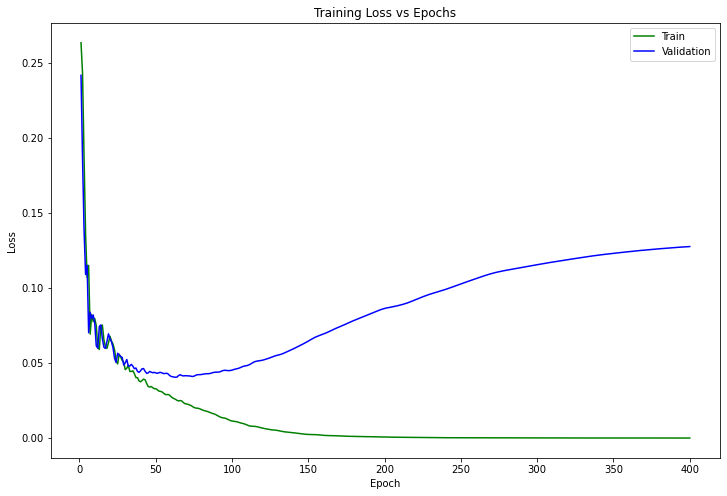

Final round loss: 
Training Loss: 5.8011717134037054e-05
Validation Loss: 0.12753193433789553
Testing Loss: 0.1344166805909439


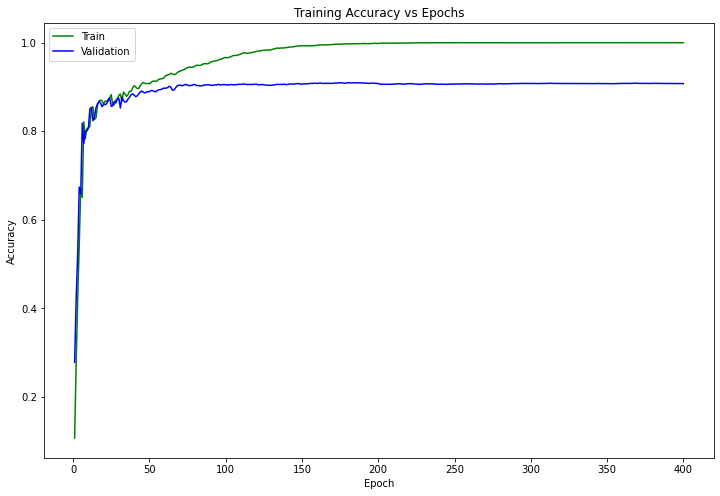

Final round accuracy: 
Final Training Accuracy: 0.9998
Final Validation Accuracy: 0.9073333333333333
Final Testing Accuracy: 0.9023494860499266


In [306]:
plot_curves(train_accuracy, train_loss, valid_accuracy, valid_loss, test_accuracy, test_loss)